# Pivot Points - Strategy - Backtesting 

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
from backtesting._plotting import set_bokeh_output
set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [24, 12]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

/home/zuongthao/PycharmProjects/algo-stock/venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.4,1342.4,1344.2,5075
2025-02-07 14:20:00,1344.2,1344.7,1343.6,1344.0,4865
2025-02-07 14:25:00,1344.1,1344.2,1342.8,1343.3,5013


In [27]:
def prepare_data(df):
    df_daily = df.resample('1D').agg({'High': 'max', 'Low': 'min', 'Close': 'last'})
    df_daily["Pivot"] = (df_daily["High"] + df_daily["Low"] + df_daily["Close"]) / 3
    df_daily["R1"] = 2 * df_daily["Pivot"] - df_daily["Low"]
    df_daily["S1"] = 2 * df_daily["Pivot"] - df_daily["High"]
    df_daily["R2"] = df_daily["Pivot"] + (df_daily["High"] - df_daily["Low"])
    df_daily["S2"] = df_daily["Pivot"] - (df_daily["High"] - df_daily["Low"])
    df_daily["Pivot"] = df_daily["Pivot"].shift(1)
    df_daily["S1"] = df_daily["S1"].shift(1)
    df_daily["R1"] = df_daily["R1"].shift(1)
    df_daily["S2"] = df_daily["S2"].shift(1)
    df_daily["S2"] = df_daily["S2"].shift(1)
    df = df.merge(df_daily[['Pivot', 'R1', 'S1', 'R2', 'S2']], left_on=pd.to_datetime(df.index.date), right_index=True, how='left')
    return df


In [28]:
class MainStrategy(Strategy):
    risk_reward_ratio = 3.1
    max_sl = 3.9

    def init(self):
        self._broker._cash = 1500
        self.pivot = self.I(lambda: self.data.Pivot)
        self.r1 = self.I(lambda: self.data.R1)
        self.s1 = self.I(lambda: self.data.S1)
        super().init()

    def next(self):
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position:
                self.position.close()
            return
        #
        if self.position:
            return
        #
        if self.data.Low[-1] <= self.s1[-1] and self.data.Close[-1] > self.s1[-1]:
            sl = self.data.Close[-1] - self.max_sl
            tp = self.data.Close[-1] + self.max_sl * self.risk_reward_ratio
            self.buy(size=1, sl=sl, tp=tp)

        elif self.data.High[-1] >= self.r1[-1] and self.data.Close[-1] < self.r1[-1]:
            sl = self.data.Close[-1] + self.max_sl
            tp = self.data.Close[-1] - self.max_sl * self.risk_reward_ratio
            self.sell(size=1, sl=sl, tp=tp)

In [29]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [30]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [32]:
stats

Start                     2020-11-04 09:00:00
End                       2025-02-07 14:45:00
Duration                   1556 days 05:45:00
Exposure Time [%]                   19.181431
Equity Final [$]                   1590.00973
Equity Peak [$]                    1621.72919
Return [%]                           6.000649
Buy & Hold Return [%]               47.794037
Return (Ann.) [%]                    2.523921
Volatility (Ann.) [%]                5.001688
Sharpe Ratio                         0.504614
Sortino Ratio                        0.842747
Calmar Ratio                         0.425449
Max. Drawdown [%]                   -5.932377
Avg. Drawdown [%]                    -0.55588
Max. Drawdown Duration      573 days 00:05:00
Avg. Drawdown Duration       25 days 05:30:00
# Trades                                  434
Win Rate [%]                        39.170507
Best Trade [%]                       1.492956
Worst Trade [%]                     -0.469219
Avg. Trade [%]                    

In [33]:
stats['_trades'].tail(15)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
419,1,30292,30316,1308.89255,1304.50,-4.39255,-0.003356,2024-12-04 10:50:00,2024-12-04 14:15:00,None,0 days 03:25:00
420,-1,30346,30352,1309.10715,1313.20,-4.09285,-0.003126,2024-12-05 11:05:00,2024-12-05 13:00:00,None,0 days 01:55:00
421,-1,30430,30469,1346.09605,1334.31,11.78605,0.008756,2024-12-11 09:35:00,2024-12-11 14:15:00,None,0 days 04:40:00
422,-1,30483,30497,1345.19632,1349.70,-4.50368,-0.003348,2024-12-12 09:45:00,2024-12-12 10:55:00,None,0 days 01:10:00
423,-1,30510,30523,1345.29629,1340.20,5.09629,0.003788,2024-12-12 13:25:00,2024-12-12 14:30:00,None,0 days 01:05:00
424,1,30526,30526,1335.30047,1330.80,-4.50047,-0.003370,2024-12-13 09:05:00,2024-12-13 09:05:00,None,0 days 00:00:00
425,1,30533,30574,1334.60026,1336.00,1.39974,0.001049,2024-12-13 09:40:00,2024-12-13 14:30:00,None,0 days 04:50:00
426,-1,30722,30727,1318.00448,1320.10,-2.09552,-0.001590,2024-12-20 14:05:00,2024-12-20 14:30:00,None,0 days 00:25:00
427,1,30902,30931,1314.99438,1320.00,5.00562,0.003807,2025-01-08 10:40:00,2025-01-08 14:30:00,None,0 days 03:50:00
428,1,30960,30977,1315.49453,1311.40,-4.09453,-0.003113,2025-01-09 11:15:00,2025-01-09 14:05:00,None,0 days 02:50:00


In [34]:
# bt.plot()

In [35]:
_trades = stats['_trades']
_trades['PnL'].min()

-4.843340000000126

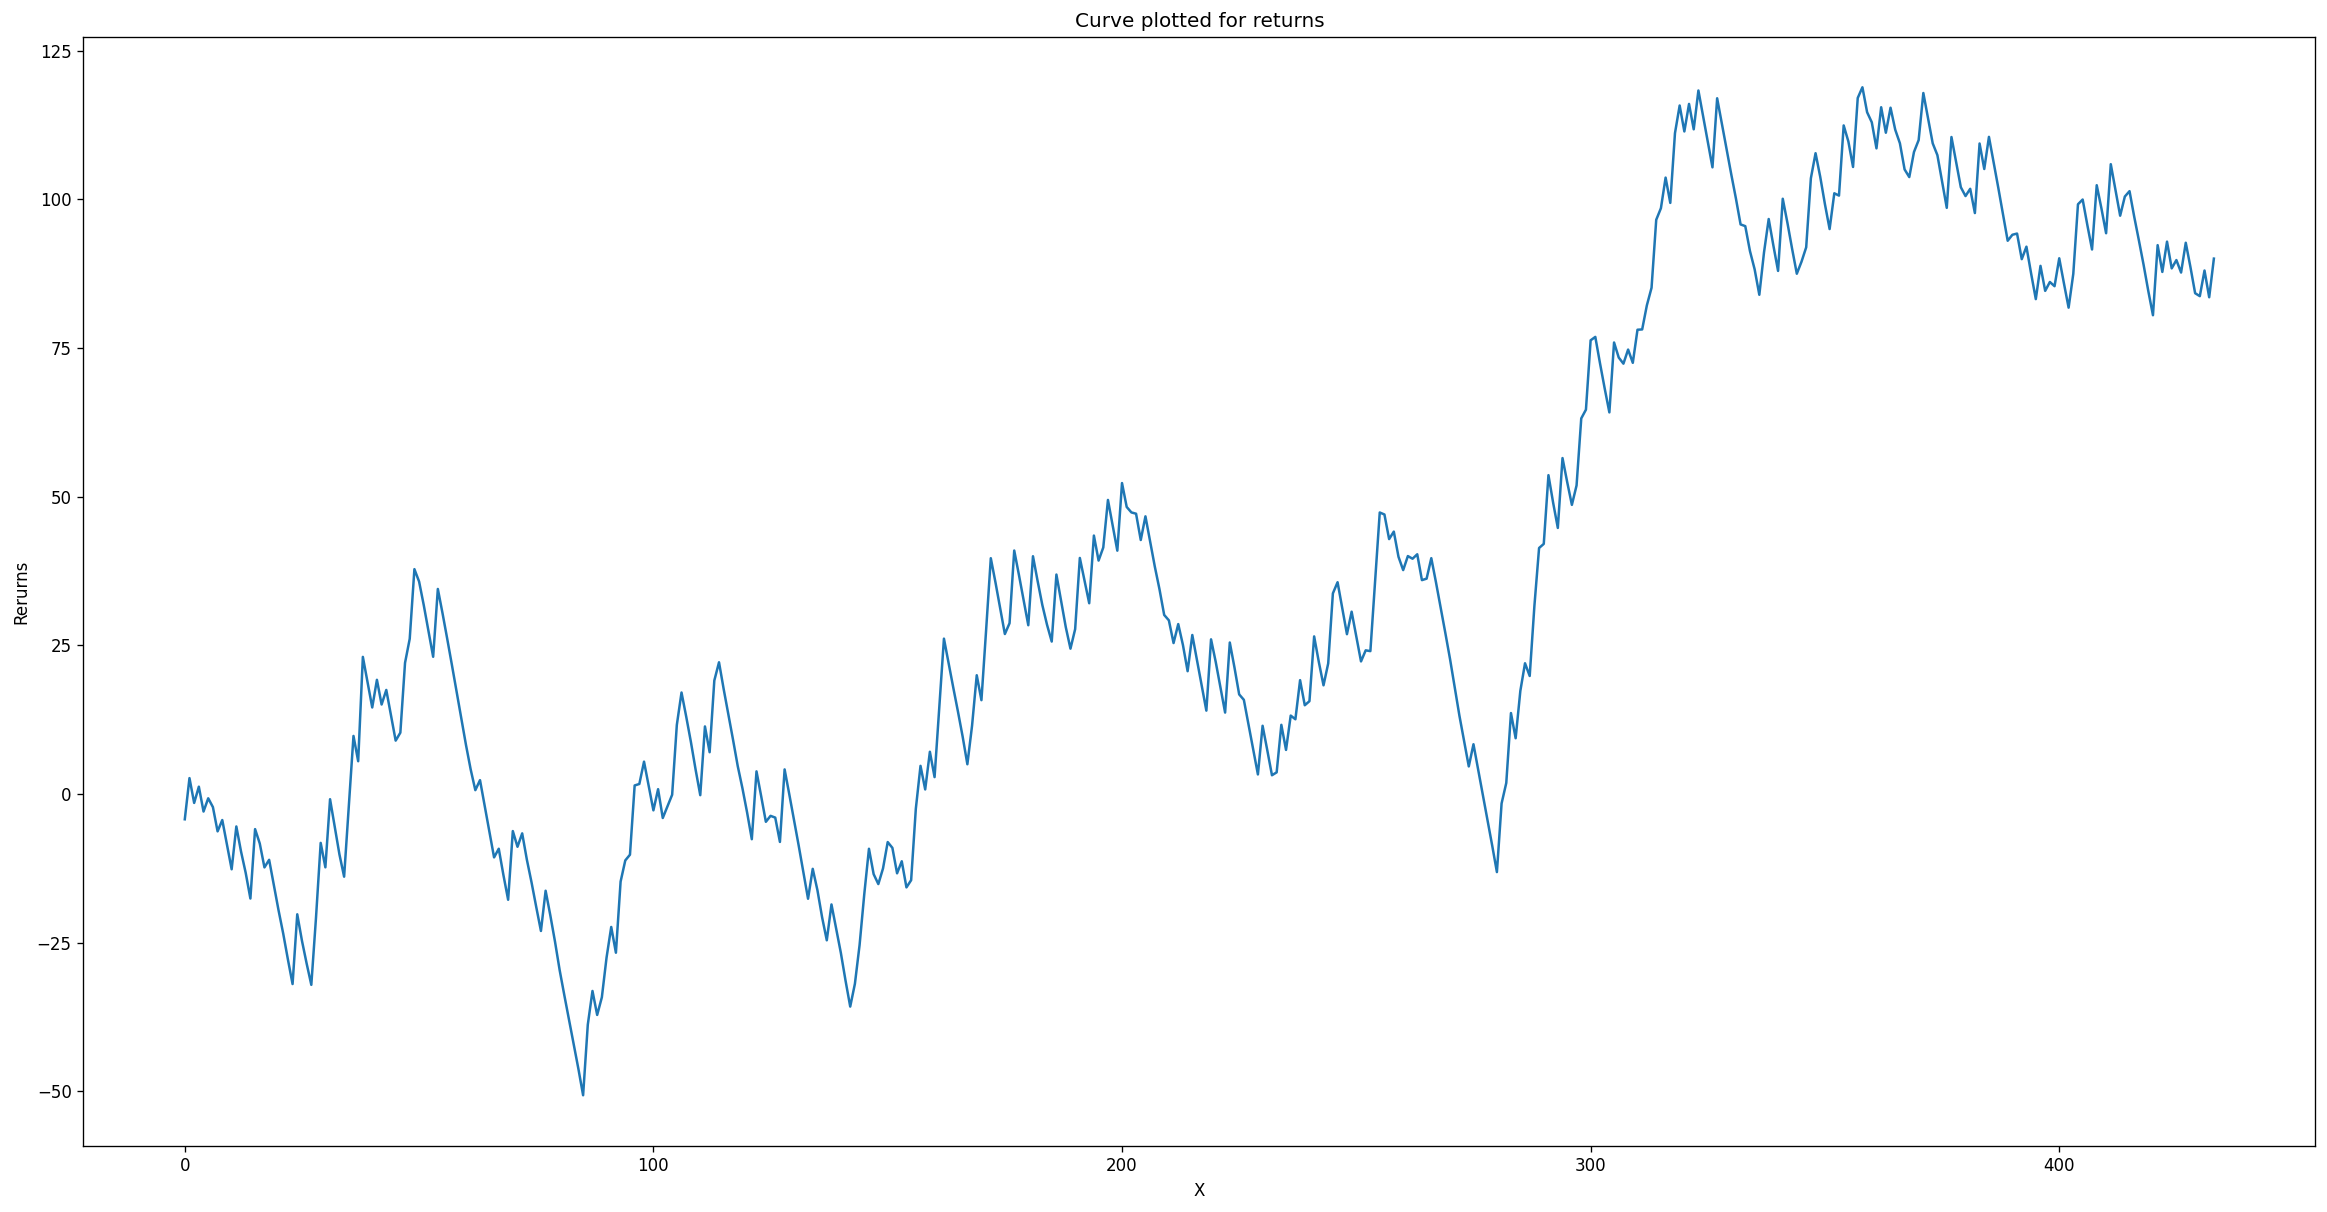

In [36]:
copy_trades = _trades.copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

# Optimize

In [37]:
max_sl_params = [x / 10.0 for x in range(20, 45)]
risk_reward_ratio_params = [x / 10.0 for x in range(20, 40)]
optimize_stats, heatmap = bt.optimize(max_sl=max_sl_params,
                                      risk_reward_ratio=risk_reward_ratio_params,
                                        maximize='Return [%]',
                                        random_state=0,
                                        return_heatmap=True)

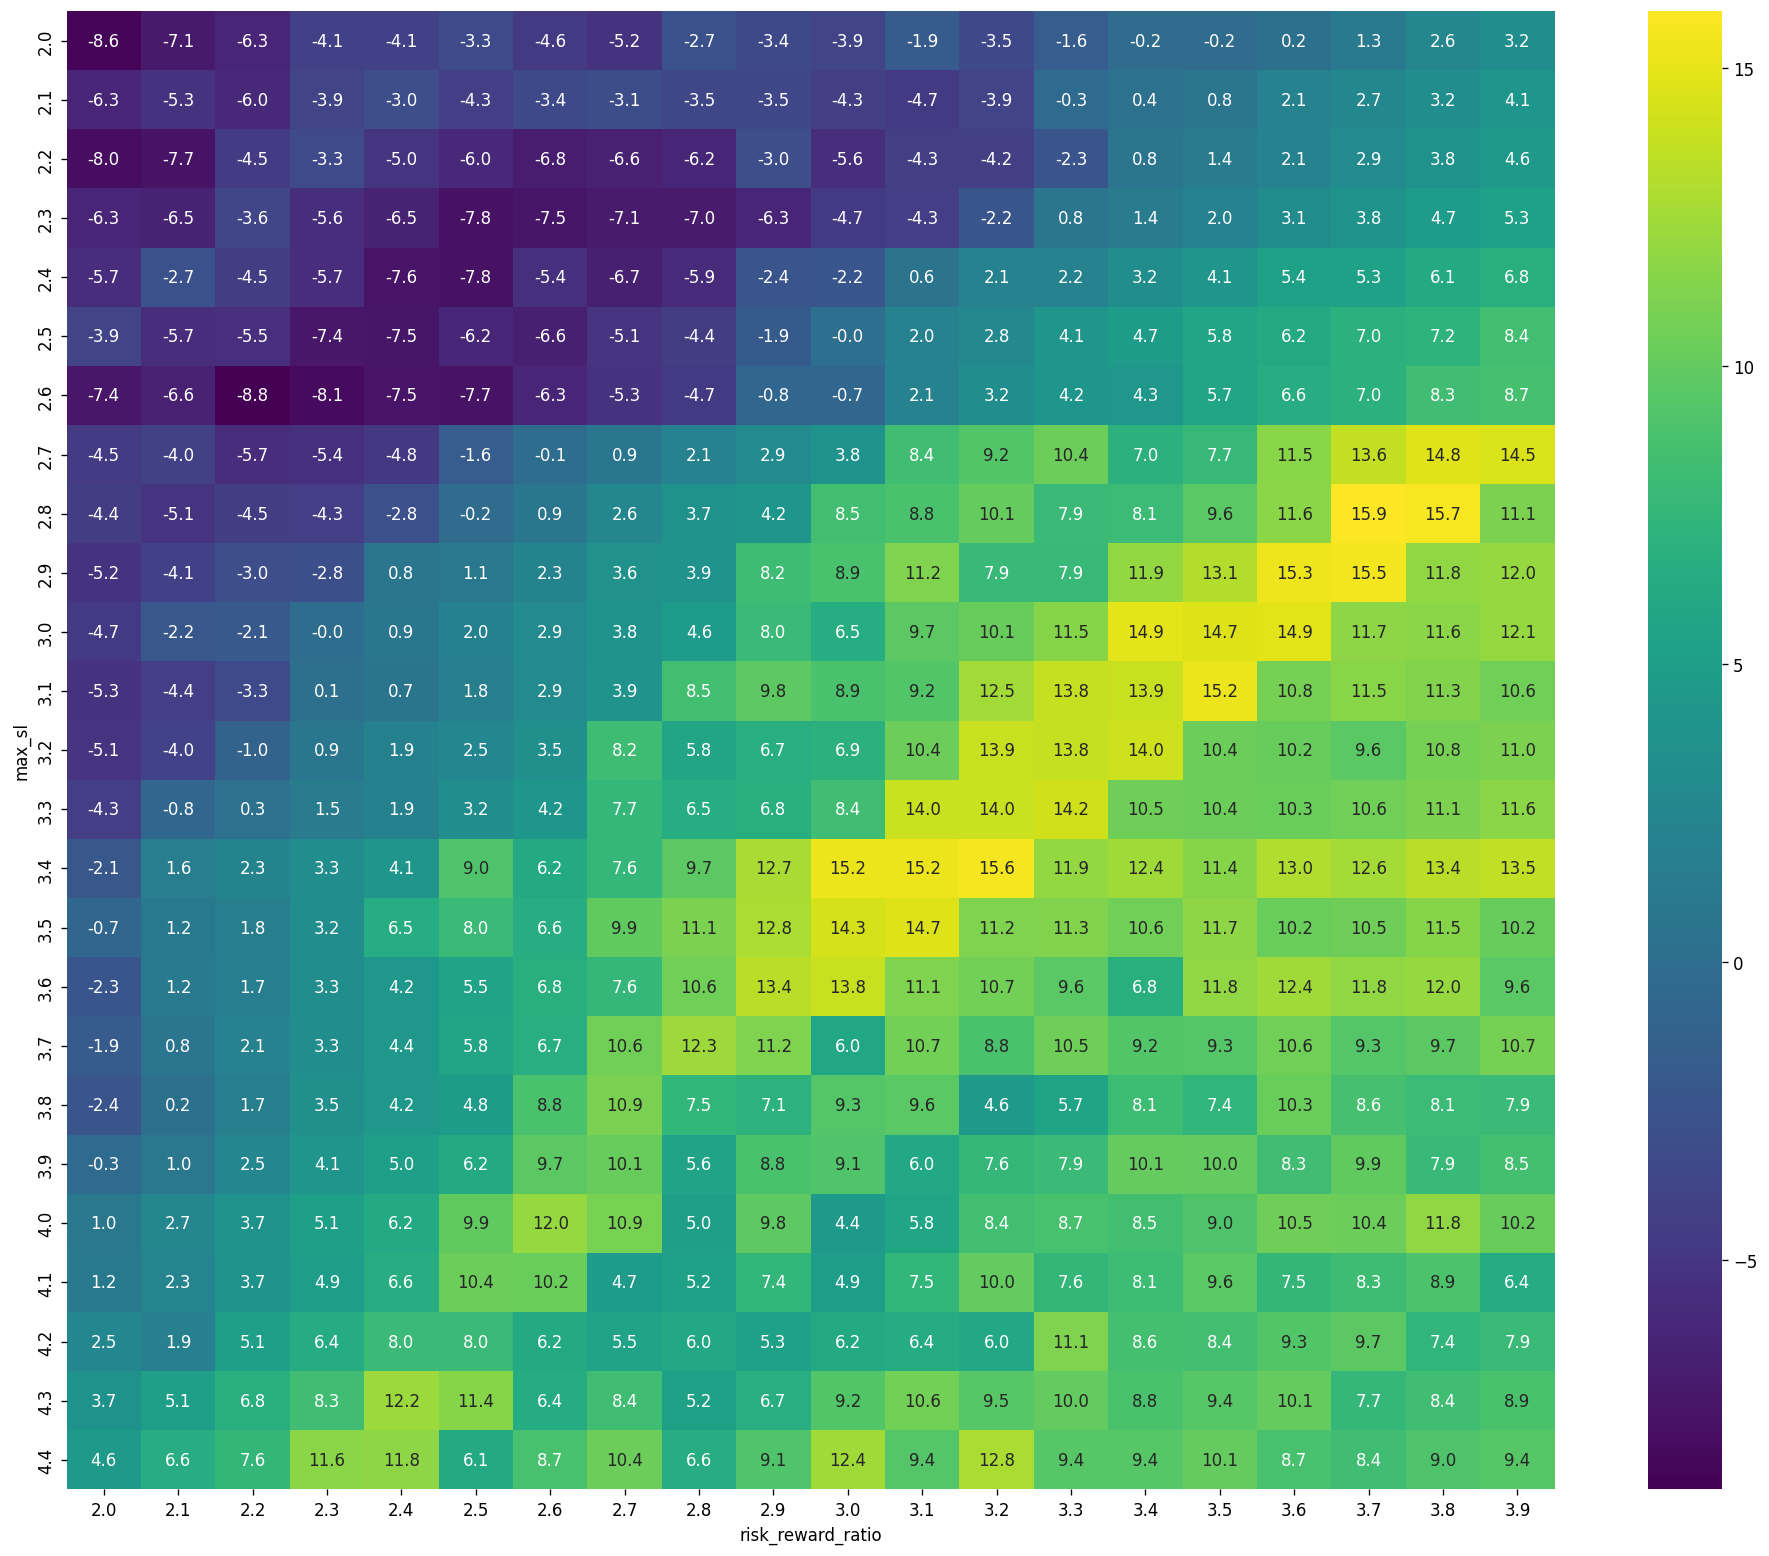

In [38]:
import seaborn as sns
# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(20, 16))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.1f')
plt.show()